# Data Exploration

In [1]:
# Initialize Spark, RERUN EVERY TIME!
from pyspark import SparkConf, SparkContext

SparkContext.setSystemProperty('spark.executor.memory', '50g')

conf = SparkConf()\
        .setMaster("spark://c650mnp06:7077")\
        .setAppName("Sandbox")

sc = SparkContext(conf = conf)

In [2]:
# Index Constants
TRANS_ALLOC = "cast-allocation-ornl"
TRANS_STEP  = "cast-allocation-step-ornl"
STEP_HIST   = "cast-db-csm_step_history-ornl-*"
NODE_HIST   = "cast-db-csm_allocation_node_history-ornl-*"
ALLOC_HIST  = "cast-db-csm_allocation_history-ornl-*"

# Set the Connection Constants
NODES       = "10.7.4.15,10.7.4.17"
PORTS       = "9200"

# Defining Node  History

We want to get some data from the allocation node history table before anything else and leverage Elasticsearch. Step 1 is to determine which fields we want and how we're going to aggregate them (tons of data is great, but skew can be just as if not more interesting) Using this we can start to refine the allocation data to make it easier to run analytics on the allocation data. The following variables are all in the **data** object. The data will be condensed to pivot on the **data.allocation_id**. 

**NOTE:** This is one way of analyzing the data. Other analytics may be written using the raw allocation node data, but I'm interested in a few specific indicators to apply to the overall allocation.

* **memory_usage_max**
    * Should store the Average and the Maximum values.
    * **mem_usage_avg**
    * **mem_usage_max**
* **gpu_usage**
    * Trickier, do we want the total sum or average of all nodes?
    * **gpu_usage_avg**
* **gpfs_read**
    * I think the average across all nodes should be appropriate to get a sense for GPFS usage in general.
    * **gpfs_read_avg**
* **gpfs_write**
    * I think the average across all nodes should be appropriate to get a sense for GPFS usage in general.
    * **gpfs_write_avg**
* **allocation_id**
    * Pivot value, summations and math operations pivot on this data point.
* **cpu_usage**
    * Average should be fine, can show trends. If combined with median, could indicate uneven workload.
    * **cpu_usage_avg**
    * **cpu_usage_median**
* **ib_tx**
    * **ib_tx_avg** 
* **ib_rx**
    * **ib_rx_avg** 
* **energy**
    * **energy_avg**
    * **energy_median**

# A brief note about the node_history table

In earlier versions of CSM (pre-1.5.0) The node history table would cache all state changes of the node. This had an unintended consequence of making queries more complicated and reducing the overall readablity of the records for a allocation. This *feature* has been removed in CSM releases as of 1.5.0. To fix your existing tables in BDS the following query can be **POSTed** to elasticsearch (I ran this in the kibana dev console).

```
POST <index_name>/_delete_by_query?wait_for_completion=false
{
  "query": {
    "term": {
      "data.state": "running"
    }
  }
}
```

This will kick off a job which deletes all entries in the *running* state. This makes the following operations run *much* faster in environments with this problem. Reducing the total number of records by as much as 3/4.

In [3]:
from datetime import datetime
# Set up the time range
date_format= '%Y-%m-%d'
search_format='date_time_no_millis'

start_time="2019-01-01T01:00:00Z"
end_time="2019-03-02T01:00:00Z"

timerange='''{{
    "lte"    : "{2}",
    "gte"    : "{0}",
    "format" : "{1}"
}}'''.format(start_time, search_format, end_time)

In [4]:
# Let's Write a Query!

NHistQuery = '''
{{ 
    "query" : {{
        "range" : {{
             "data.history_time" : {0}
        }}
    }}
}}'''.format(timerange)

#NHistQuery='{ "query":{ "match_all":{ } } }'

print(NHistQuery)
NHistFields = ["data.allocation_id", "data.node_name", "data.ib_tx", "data.ib_rx", "data.memory_usage_max", "data.gpu_usage",
                "data.gpfs_read", "data.gpfs_write", "data.gpu_energy", "data.cpu_usage", "data.energy", "data.state"]

es_conf = {"es.resource": "{0}".format(NODE_HIST),
          "es.nodes"    : NODES,
          "es.port"     : PORTS,
          "es.query"    : NHistQuery, 
          "es.read.field.include" : ",".join(NHistFields) }



nodeHist = sc.newAPIHadoopRDD("org.elasticsearch.hadoop.mr.EsInputFormat",\
                         "org.apache.hadoop.io.NullWritable", \
                         "org.elasticsearch.hadoop.mr.LinkedMapWritable",conf=es_conf)
#nodeHist.first()


{ 
    "query" : {
        "range" : {
             "data.history_time" : {
    "lte"    : "2019-03-02T01:00:00Z",
    "gte"    : "2019-01-01T01:00:00Z",
    "format" : "date_time_no_millis"
}
        }
    }
}


In [5]:
from operator import add

hSchema = (  "allocation_id",  ("memory_usage_max", "gpu_usage", 
                                "gpu_energy", "gpfs_write", "gpfs_read", "cpu_usage", 
                                "ib_tx", "ib_rx", "energy"))

hSchDict = {f:i for i,f in enumerate(hSchema[1])}

def mapObj( o ):
    obj  = o[1]["data"]
    
    # Build the tuple, if the field is None set to 0.
    oTup = tuple( 
        obj.get(field) 
            if obj.get(field) is not None and obj.get(field) > 0 else 0  
                for field in hSchema[1]  
    )
    return (obj[hSchema[0]], oTup)
    

def reduceObj(x,y):
    return tuple(map(add, x,y))
      

nHist = nodeHist.map(mapObj)
nHist.first()
nHist.cache()

PythonRDD[4] at RDD at PythonRDD.scala:53

In [6]:
# This time I want access to more statistics so we can determine skew/variance.
from pyspark.mllib.stat import Statistics
from pyspark.statcounter import StatCounter

nHistAgg = nHist.aggregateByKey([ StatCounter() for i in range(0,len(hSchema[1]))],
                     lambda a,b : tuple( v.merge(b[i]) for i,v in enumerate(a)),
                     lambda a,b : tuple( v.mergeStats(b[i]) for i,v in enumerate(a)))



# What next?
The next step is to flatten our stat counter objects.

Using our stated goals above I want to have the following variables in the value tuple:

* *memory_usage_max*
 * `t[0].max()`
* *memory_usage_max_mean*
 * `t[0].mean()`
 
* *gpu_usage_mean*
 * `t[1].mean()`
* *gpu_usage_std*
 * `t[1].stdev()`
 * **note** : I find the std to be interesting, because it indicates the spread of thhe workload.
 
* *gpu_energy_mean*
 * `t[2].mean()`
* *gpu_energy_std*
 * `t[2].stdev()`
 
* *gpfs_write_mean*
 * `t[3].mean()`
 
* *gpfs_read_mean*
 * `t[4].mean()`

* *cpu_usage_mean*
 * `t[5].mean()`
* *cpu_usage_std*
 * `t[5].stdev()`

* *ib_tx_mean*
 * `t[6].mean()`
 
* *ib_rx_mean*
 * `t[7].mean()`
 
* *energy_mean*
 * `t[8].mean()`
* *energy_std*
 * `t[8].stdev()`

In [7]:
hSchema = ("memory_usage_max_mean","memory_usage_max", "gpu_usage_mean", 
           "gpu_usage", "gpu_usage_std", "gpu_energy", "gpu_energy_mean", 
           "gpfs_read_mean", "gpfs_write_mean", "cpu_usage", "cpu_usage_mean", 
           "cpu_usage_std", "ib_tx","ib_tx_mean", "ib_rx", "ib_rx_mean",
           "energy", "energy_mean", "energy_std")

nHistReduced = nHistAgg.map(lambda b : ( b[0],(
         int(b[1][hSchDict["memory_usage_max"]].mean()),
         int(b[1][hSchDict["memory_usage_max"]].max()),
         int(b[1][hSchDict["gpu_usage"]].sum()),
         int(b[1][hSchDict["gpu_usage"]].mean()),
         float(b[1][hSchDict["gpu_usage"]].stdev()),
        int(b[1][hSchDict["gpu_energy"]].sum()),
         int(b[1][hSchDict["gpu_energy"]].mean()),
         int(b[1][hSchDict["gpfs_read"]].mean()),
         int(b[1][hSchDict["gpfs_write"]].mean()),
         int(b[1][hSchDict["cpu_usage"]].sum()),
         int(b[1][hSchDict["cpu_usage"]].mean()),
         float(b[1][hSchDict["cpu_usage"]].stdev()),
         int(b[1][hSchDict["ib_tx"]].sum()),
         int(b[1][hSchDict["ib_tx"]].mean()),
         int(b[1][hSchDict["ib_rx"]].sum()),
         int(b[1][hSchDict["ib_rx"]].mean()),
         int(b[1][hSchDict["energy"]].sum()),
         int(b[1][hSchDict["energy"]].mean()),
         float(b[1][hSchDict["energy"]].stdev())
    )))

#nHistReduced = nHistReduced.map(lambda b : (b[0], ( v if v > 0 else 0 for v in b[1]) ) )

# Allocation Node History Reduced
At this point we have a full allocation node history.

In [8]:
# Let's Write a Query!

allocQuery = '''
{{ 
    "query" : {{
        "range" : {{
             "data.end_time" : {0}
        }}
    }}
}}'''.format(timerange)

print(allocQuery)
allocFields = ["data.allocation_id"   ,  "data.job_submit_time", "data.begin_time"    , "data.end_time" , 
               "data.projected_memory",   "data.state"         , "data.ssd_min"  , 
               "data.ssd_max"         , "data.user_name"       , "data.num_processors", "data.num_nodes", 
               "data.launch_node_name", "data.time_limit"      , "data.isolated_cores", "data.num_gpus" ]

es_conf = {"es.resource": "{0}".format(ALLOC_HIST),
          "es.nodes"    : NODES,
          "es.port"     : PORTS,
          "es.query"    : allocQuery, 
          "es.read.field.include" : ",".join(allocFields) }



aHist = sc.newAPIHadoopRDD("org.elasticsearch.hadoop.mr.EsInputFormat",\
                         "org.apache.hadoop.io.NullWritable", \
                         "org.elasticsearch.hadoop.mr.LinkedMapWritable",conf=es_conf)


{ 
    "query" : {
        "range" : {
             "data.end_time" : {
    "lte"    : "2019-03-02T01:00:00Z",
    "gte"    : "2019-01-01T01:00:00Z",
    "format" : "date_time_no_millis"
}
        }
    }
}


In [9]:
allocSchema = ("allocation_id"    , ( "job_submit_time", "begin_time"    , "end_time"      ,
               "projected_memory" ,   "state"          , "ssd_min"       ,
                "ssd_max"         ,   "user_name"      , "num_processors", "num_nodes"     , 
                "launch_node_name",   "time_limit"     , "isolated_cores", "num_gpus" ))

def mapAHistObj( o ):
    obj  = o[1]["data"]
    
    # Build the tuple, if the field is None  set to 0.
    oTup = tuple( obj[field] if obj[field] is not None  else 0  for field in allocSchema[1]  )
    return (obj[allocSchema[0]], oTup)


aHistReduced = aHist.map(mapAHistObj)

In [10]:
jSchema = tuple([allocSchema[0]]) + allocSchema[1] + hSchema

def mapJoin(obj):
    return tuple([obj[0]]) + obj[1][0] + obj[1][1]

joinedHist= aHistReduced.join(nHistReduced).map(mapJoin)
joinedHist.cache()

PythonRDD[19] at RDD at PythonRDD.scala:53

In [11]:
# Import the goods.
import json
import math
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pyspark.ml

from pyspark.mllib.stat import Statistics
from pyspark.mllib.feature import StandardScaler
from pyspark.mllib.feature import Normalizer

from pyspark.mllib.util import MLUtils

import pyspark.sql.functions as F
from pyspark.sql.functions import datediff

from   pyspark.sql import SparkSession

import matplotlib
import seaborn as sns
from scipy.stats import norm

%matplotlib inline 


In [12]:
# Monkey patch  the DataFrame to have a makeDummies function.
def makeDummies(self, colName):
    if self.dummyCols is None:
        self.dummyCols = dict()
        self.dummyCols["_base"] = self.columns
        #del self.dummyCols["_base"][0]
        
        
    categ = self.select(colName).distinct().rdd.flatMap(lambda x: x).collect()
    exps  = [ F.when(F.col(colName) == cat, 1).otherwise(0).alias(str(cat)) for cat in categ ]
    
    self.dummyCols[colName] = categ    
    
    self.dummyCols["_base"].remove(colName)
    
    newDF =  self.select( self.columns  + exps).drop(colName)
    newDF.dummyCols = self.dummyCols
    
    return newDF

def getDummyCols(self, *args):
    if self.dummyCols is None:
        self.dummyCols = dict()

    if len(args) is 0:
        args=self.dummyCols.keys()
        
    dCols = list()
    for col in args :
        dCols += self.dummyCols.get(col, [])
        
    return dCols

def getBase(self):
    if self.dummyCols is not None:
        return self.dummyCols["_base"]
    else:
        return []

def makeDate(self, colName):
    return self.withColumn(colName, self[colName].cast("timestamp"))
  

def dropSafe(self):
    dummyCache=self.dummyCols
    self.drop()
    self.dummyCols=dummyCache
    return self

# Drop any values where Max=Min
def cleanFeatures(self, args ):
    newDF = self
    newDF.dummyCols = self.dummyCols
    for col in args:
        if col is not None:
            des = self.describe(col)
            values = list(map(lambda val :  int(math.floor(float(val))), des.rdd.values().collect()))
            
            # If std is 0, drop the column from the frame.
            if values[3] == values[4]:
                print("Dropping {0} no variance detected".format(col))
                # Cache the dummy cols
                dummyCols = newDF.dummyCols
                newDF = newDF.drop(col)
                
                #  Scan the column table and drop non variant columns.
                for group in dummyCols.keys():
                    if col in dummyCols[group]:
                        dummyCols[group].remove(col)
                        break
                
                newDF.dummyCols = dummyCols
                        
                
                            
    return newDF

def describeList(self, args):    
    for col in args:
        if col is not None:
            des = self.describe(col)
            des.show()       
            
def processDateRange(self, startCol, endCol, deltaField):
    newDF = self.withColumn(deltaField, F .unix_timestamp(endCol) - F.unix_timestamp(startCol))
    
    if self.dummyCols is None:
        self.dummyCols = dict()
        self.dummyCols["_base"] = self.columns
        
    newDF.dummyCols = self.dummyCols
    newDF.dummyCols["_base"].append(deltaField)
    return newDF

def addTimeOfDay(self, *args):
    
    if self.dummyCols is None:
        self.dummyCols = dict()
        self.dummyCols["_base"] = self.columns

    newDF = self
    dummyCols = self.dummyCols
    
    for col in args:
        dummyCols["_base"].append("tod_{0}".format(col))
        dummyCols["_base"].append("tow_{0}".format(col))

        newDF = newDF.withColumn("tod_{0}".format(col), F.hour(self[col]))\
                    .withColumn("tow_{0}".format(col), F.dayofweek(self[col]))
    
    
    newDF.dummyCols = dummyCols       
    return newDF
                                
pyspark.sql.dataframe.DataFrame.makeDummies      = makeDummies
pyspark.sql.dataframe.DataFrame.dummyCols        = None
pyspark.sql.dataframe.DataFrame.makeDate         = makeDate
pyspark.sql.dataframe.DataFrame.getDummyCols     = getDummyCols
pyspark.sql.dataframe.DataFrame.getBase          = getBase
pyspark.sql.dataframe.DataFrame.dropSafe         = dropSafe
pyspark.sql.dataframe.DataFrame.cleanFeatures    = cleanFeatures
pyspark.sql.dataframe.DataFrame.describeList     = describeList
pyspark.sql.dataframe.DataFrame.processDateRange = processDateRange
pyspark.sql.dataframe.DataFrame.addTimeOfDay     = addTimeOfDay

In [13]:
spark = SparkSession(sc)
jDF = joinedHist.toDF(jSchema)


In [14]:
uJDF = jDF.makeDate("job_submit_time")\
    .makeDate("begin_time")\
    .makeDate("end_time")\
    .processDateRange("begin_time","end_time","job_run_time")\
    .processDateRange("job_submit_time","begin_time","submit_to_begin")\
    .processDateRange("job_submit_time","end_time","submit_to_end")\
    .addTimeOfDay("job_submit_time","begin_time","end_time")\
    .makeDummies("launch_node_name")\
    .makeDummies("state")\
    .makeDummies("user_name")


In [15]:
uJDF        = uJDF.dropSafe()                 # Drop Rows with Null fields
normCols    = uJDF.getDummyCols("_base")[4:]  # Get the columns that need to be normalized.

uJDF        = uJDF.cleanFeatures(normCols)    # Drop columns withh no variance
featureCols = uJDF.getDummyCols()[4:]             # Build the feature columns
normCols    = uJDF.getDummyCols("_base")[4:]  # Get the columns that need to be normalized (changed above)


features    = uJDF.rdd.map(lambda row: row[4:]) # Build the feature rdd.


Dropping projected_memory no variance detected
Dropping ssd_min no variance detected
Dropping ssd_max no variance detected
Dropping num_processors no variance detected
Dropping isolated_cores no variance detected
Dropping num_gpus no variance detected


In [16]:
uJDF.describeList(normCols)

+-------+------------------+
|summary|         num_nodes|
+-------+------------------+
|  count|             36767|
|   mean|57.212772323007044|
| stddev| 266.8534801423103|
|    min|                 1|
|    max|              4600|
+-------+------------------+

+-------+-----------------+
|summary|       time_limit|
+-------+-----------------+
|  count|            36767|
|   mean|6176.054070226018|
| stddev|7524.273393686262|
|    min|               60|
|    max|            86400|
+-------+-----------------+

+-------+---------------------+
|summary|memory_usage_max_mean|
+-------+---------------------+
|  count|                36767|
|   mean| 2.209214760921114E10|
| stddev| 5.124356569921979E10|
|    min|                    0|
|    max|         560641080320|
+-------+---------------------+

+-------+--------------------+
|summary|    memory_usage_max|
+-------+--------------------+
|  count|               36767|
|   mean|2.389402420603693...|
| stddev|5.545386124677685E10|
|    min| 

In [17]:

corr_matrix = Statistics.corr(features, method="pearson")
pdJDF       = pd.DataFrame(corr_matrix)
pdJDF.index,pdJDF.columns = featureCols,featureCols
pdJDF.head(5)

,num_nodes,time_limit,memory_usage_max_mean,memory_usage_max,gpu_usage_mean,gpu_usage,gpu_usage_std,gpu_energy,gpu_energy_mean,gpfs_read_mean,...,hoerz,bnlu,jtkrogel,wozniak,gjost2,josed,rlarsen,walksloud,bjoo,akorzh
num_nodes,1.000000,0.131716,0.106485,0.123713,0.097308,0.035415,0.052657,NaN,0.022334,0.001894,...,-0.004229,-0.002080,-0.001554,-0.011239,-0.004662,-0.001099,0.009666,-0.094434,-0.002413,-0.004873
time_limit,0.131716,1.000000,0.039307,0.046749,0.492442,0.610748,0.428661,NaN,0.055606,0.024062,...,0.003330,-0.009782,-0.004290,-0.043971,-0.007577,0.000710,0.304798,0.075188,0.098763,-0.018422
memory_usage_max_mean,0.106485,0.039307,1.000000,0.976124,0.025608,0.062958,0.036707,NaN,-0.000293,-0.006034,...,0.099391,-0.007514,-0.003138,-0.023586,-0.008397,-0.002239,-0.029262,-0.094365,0.018935,0.012035
memory_usage_max,0.123713,0.046749,0.976124,1.000000,0.022366,0.059214,0.039680,NaN,-0.000384,-0.006292,...,0.108761,-0.007705,-0.003139,-0.023552,-0.008479,-0.002238,-0.029026,-0.097287,0.015313,0.011040
gpu_usage_mean,0.097308,0.492442,0.025608,0.022366,1.000000,0.753577,0.660437,NaN,0.278991,0.038953,...,-0.001255,0.006035,-0.000793,-0.005913,-0.002378,-0.000560,0.261481,-0.057652,0.013002,-0.002746


In [18]:
pdDF = uJDF.toPandas()

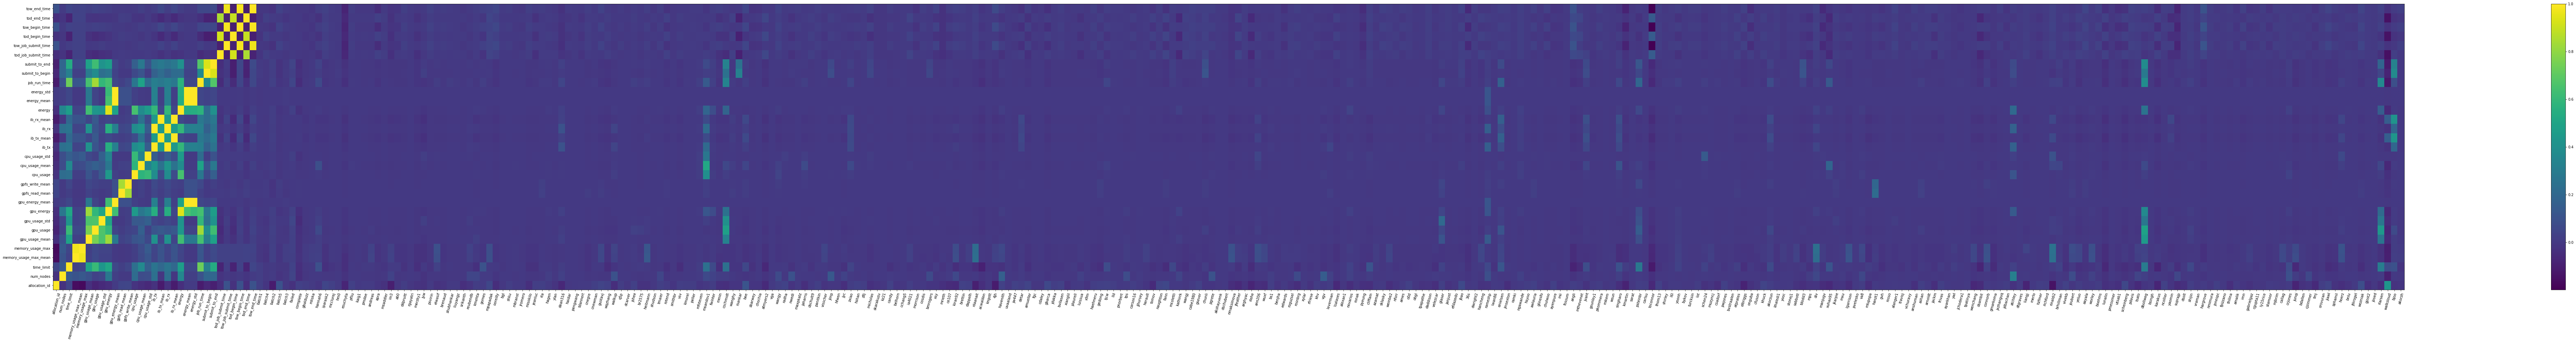

In [19]:
from matplotlib.pyplot import figure
%matplotlib inline 

cHeight = len(uJDF.getDummyCols("_base")) - 3 #+ len(uJDF.getDummyCols("launch_node_name"))

# There's a bug in the spark version?
correlation = pdDF.corr()
sCor        = correlation.head(cHeight)


# Let's do a heatmap
# Generate the correlation heat map and axis
fig, ax = plt.subplots()
hm = plt.pcolor(sCor)

fig.set_figheight(15)
fig.set_figwidth(150)

hm.EdgeColor = [1, 0.7, 0.3];
hm.LineWidth = 6;

# Move ticks and labels to the center
ax.set_xticks(np.arange(sCor.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(sCor.shape[0]) + 0.5, minor=False)

# Insert labels
ax.set_xticklabels(sCor.columns, minor=False)
ax.set_yticklabels(sCor.index, minor=False)

# Rotate label
plt.xticks(rotation=75)

# Plot the color guide and show the correlation
plt.colorbar()
plt.show()

In [20]:
# Iterate over the array and just grab things before the split line.
def getPairsToDrop( df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# Convert it to a Sequence (I think), aggregate the no-dupe feature set, 
cMag = correlation.abs().unstack()
labels=getPairsToDrop(correlation)
sortedCorrelations = cMag.drop(labels=labels).sort_values(ascending=False)


cCount=0
for idx in sortedCorrelations.index:    
    if sortedCorrelations[idx] < .5 :
        break
    cCount += 1
    print("{2}; {0}, {1}".format(idx[0],idx[1],sortedCorrelations[idx]))
    
print( "\nNumber of correlations with magnitude above .5: ", cCount)

1.0; gpu_energy_mean, energy_mean
1.0; failed, complete
0.999999999999956; gpu_energy_mean, energy_std
0.999999999999931; energy_mean, energy_std
0.9980748549368175; ib_tx, ib_rx
0.9971018916272807; ib_tx_mean, ib_rx_mean
0.9873217396101086; tow_begin_time, tow_end_time
0.9831756469806663; tow_job_submit_time, tow_begin_time
0.9761236656313554; memory_usage_max_mean, memory_usage_max
0.9704226676421791; tow_job_submit_time, tow_end_time
0.9432816719388992; gpu_energy, energy
0.9304477906266235; submit_to_begin, submit_to_end
0.9160747784201988; tod_job_submit_time, tod_begin_time
0.8960683868852851; tod_begin_time, tod_end_time
0.845647776382303; tod_job_submit_time, tod_end_time
0.8402777632957902; gpfs_read_mean, gpfs_write_mean
0.8337183920591625; gpu_usage, job_run_time
0.8264995196089066; gpu_usage_mean, gpu_energy
0.7535769997304497; gpu_usage_mean, gpu_usage
0.7282691309497086; time_limit, job_run_time
0.6765816621988234; job_run_time, submit_to_end
0.667059462817081; gpu_usage,

# Correlation assesment

## High confidence correlations
**NOTE** any correlations that are between features which are just statistical variations shall be dropped.
Additionally, most time to time correlations are dropped as they aren't completely useful.

``` python
    1;    gpu_energy_mean  energy_mean  
    1;    gpu_energy_mean  energy_std      # Implies that gpu jobs have higher variance overall.
    1;    ib_tx            ib_rx       
    1;    ib_tx_mean       ib_rx_mean      # Makes sense that tx and rx are directly correlated.
    0.84; gpfs_read_mean   gpfs_write_mean # Reads correlate with write nothing suprising here
    0.83; gpu_usage        job_run_time    # Run time has a positive correlation with gpu usage?
    0.72; time_limit       job_run_time    # Looks like users are okay with guessing their job length?
    0.64; cpu_usage        energy          # this  is ~identical to the mean usage, wonder about the  implication.
    0.64; gpu_energy       energy_mean     # Interesting correlation  here, looks like high gpu_energy doesn't mean high confidence per node usage. Indicates people not using all nodes in job?
    
    0.63; gpu_usage_mean   energy          # Mean GPU usage might have low impact on energy? or energy is more heavily impacted by something else?
    
    0.60; ib_tx            energy
    0.60; ib_rx            energy          #  Correlation implies fabric I/O  has impact, looks like they don't  interact with  other  components for energy.
    
    0.59; gpu_usage        gpu_energy      # Shouldn't this be nearly a 1???
    0.57; job_run_time     energy          # Suprisingly low correlation! Need to graph.
    0.55; gpu_energy       ib_tx           
    0.55; gpu_energy       ib_rx           # Shared PCI Bus?
    0.51; time_limit       gpu_energy      # Longer Jobs == more GPU wasted?
```

Of note the `gpu_usage` has a fairly high correlation with the `job_run_time`. Does this imply that users who run longer jobs are using the GPUs more?
 
No real slam dunks here, although the `time_limit` does seem to  be an indicator for at least `gpu_energy`.

`time_limit` and `job_run_time` have a high correlation, however it doesn't have a >50% correlation with `energy`. 

None of the variables supplied to CSM are obvious predictors for job energy usage.

# Let's GRAPH

In [21]:
# let's bring back some of the Categorical columns

launchNodes = uJDF.getDummyCols("launch_node_name")
users       = uJDF.getDummyCols("user_name")

launch = pdDF[launchNodes].dot(range(0,len(launchNodes)))\
    .map(lambda a : launchNodes[a])

users  = pdDF[users].dot(range(0,len(users)))\
    .map(lambda a : users[a])

launch.name = "launch_nodes"
users.name  = "users"

pdVDF = pd.concat([launch, users, pdDF], axis=1)

#pdDF.head()

The high value correlations


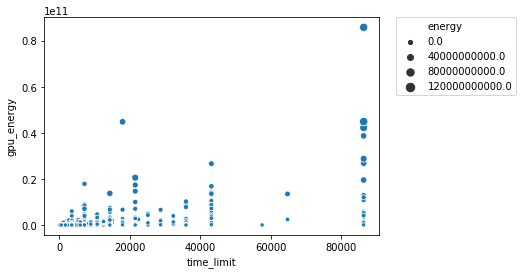

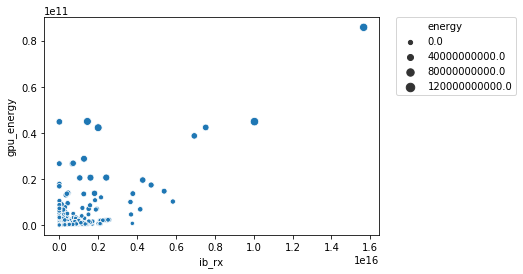

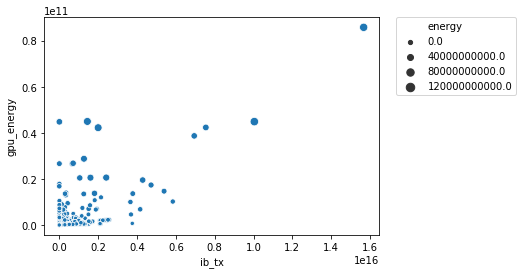

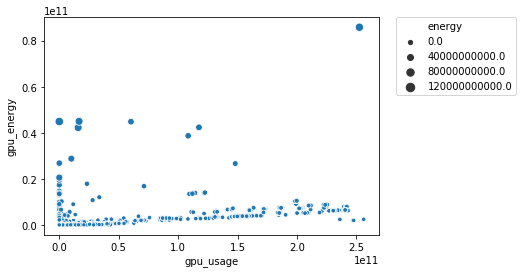

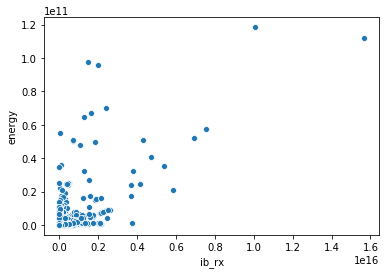

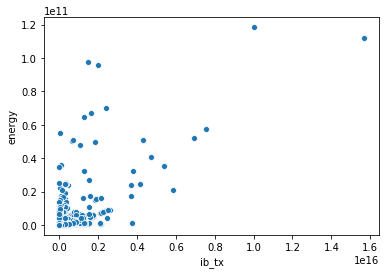

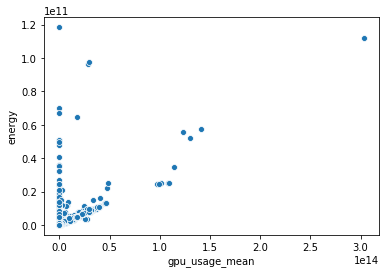

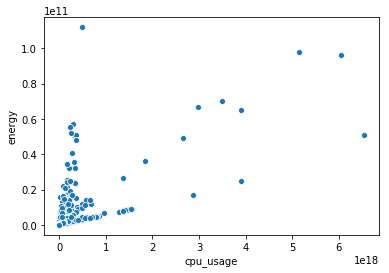

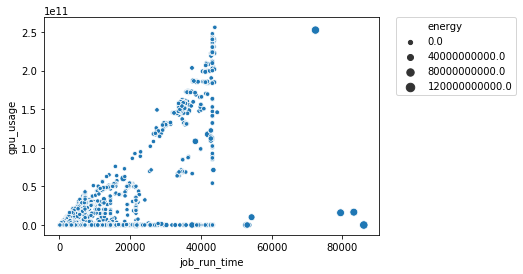

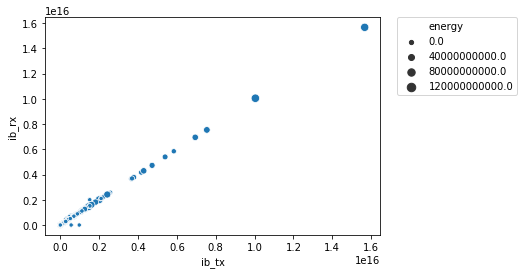

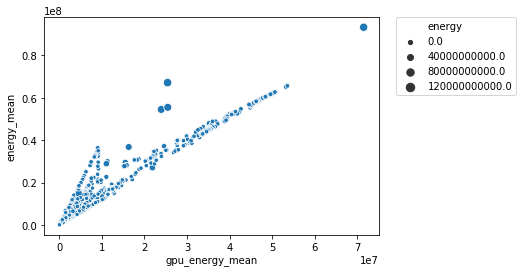

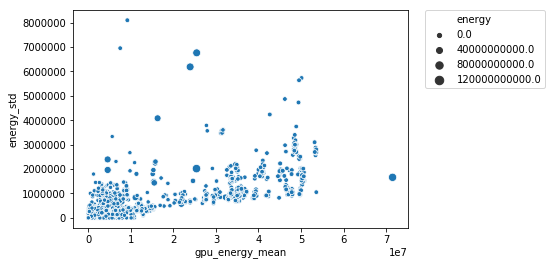

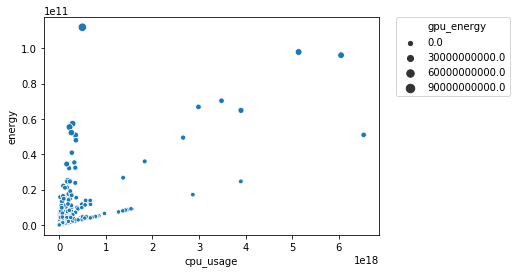

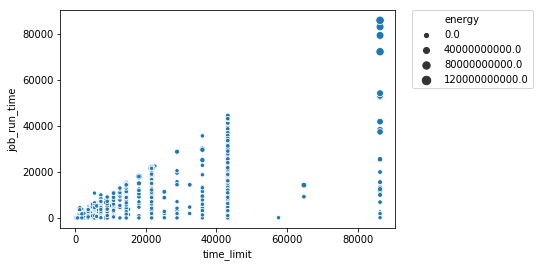

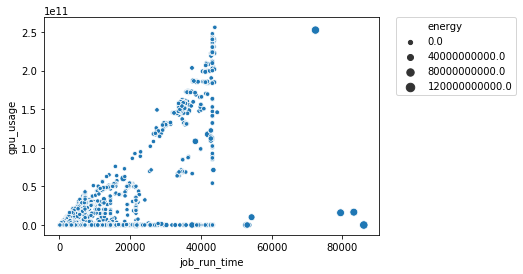

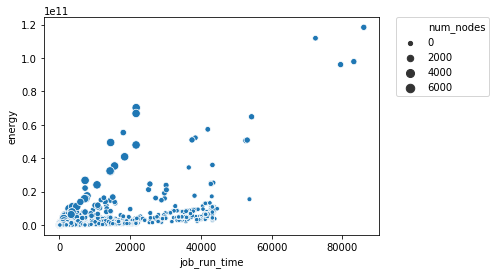

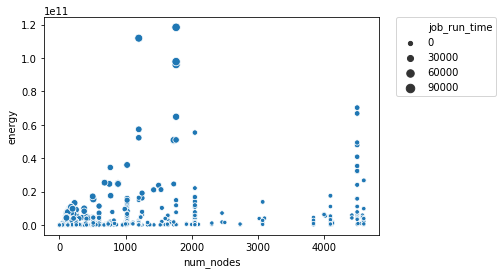

In [22]:
%matplotlib inline 

#cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
print("The high value correlations")

plt.figure()
ax2 = sns.scatterplot(x="time_limit", y="gpu_energy",  size="energy", data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
ax2 = sns.scatterplot(x="ib_rx", y="gpu_energy",  size="energy", data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
ax2 = sns.scatterplot(x="ib_tx", y="gpu_energy",  size="energy", data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
ax2 = sns.scatterplot(x="gpu_usage", y="gpu_energy", size="energy",  data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.figure()
ax2 = sns.scatterplot(x="ib_rx", y="energy",  data=pdVDF)

plt.figure()
ax2 = sns.scatterplot(x="ib_tx", y="energy",  data=pdVDF)

plt.figure()
ax2 = sns.scatterplot(x="gpu_usage_mean", y="energy",  data=pdVDF)

plt.figure()
ax2 = sns.scatterplot(x="cpu_usage", y="energy",  data=pdVDF)

plt.figure()
ax2 = sns.scatterplot(x="job_run_time", y="gpu_usage", size="energy",  data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
ax2 = sns.scatterplot(x="ib_tx", y="ib_rx", size="energy",  data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
ax2 = sns.scatterplot(x="gpu_energy_mean", y="energy_mean",  size = "energy", data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
ax2 = sns.scatterplot(x="gpu_energy_mean", y="energy_std", size = "energy", data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
ax2 = sns.scatterplot(x="cpu_usage", y="energy", size="gpu_energy", data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
ax2 = sns.scatterplot(x="time_limit", y="job_run_time", size="energy", data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
ax2 = sns.scatterplot(x="job_run_time", y="gpu_usage", size="energy", data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
ax1 = sns.scatterplot(x="job_run_time", y="energy", size="num_nodes", data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
ax2 = sns.scatterplot(x="num_nodes", y="energy", size="job_run_time", data=pdVDF)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


#cbar = plt.colorbar()


# Next Step?

It looks like the next step is to try normalizing the values and see if that gives us a bit more.

In [39]:
from pyspark.mllib.feature import Normalizer
from pyspark.mllib.util import MLUtils

# We made a feature rdd before, let's use it for normalization of our features.
normalizer = Normalizer(p=float("inf"))

nFeatures = normalizer.transform(features)
corr_matrix = Statistics.corr(features, method="pearson")
pdNDF       = pd.DataFrame(corr_matrix)
pdNDF.index,pdNDF.columns = featureCols,featureCols
pdNDF.head(5)


,num_nodes,time_limit,memory_usage_max_mean,memory_usage_max,gpu_usage_mean,gpu_usage,gpu_usage_std,gpu_energy,gpu_energy_mean,gpfs_read_mean,...,hoerz,bnlu,jtkrogel,wozniak,gjost2,josed,rlarsen,walksloud,bjoo,akorzh
num_nodes,1.000000,0.131716,0.106485,0.123713,0.097308,0.035415,0.052657,NaN,0.022334,0.001894,...,-0.004229,-0.002080,-0.001554,-0.011239,-0.004662,-0.001099,0.009666,-0.094434,-0.002413,-0.004873
time_limit,0.131716,1.000000,0.039307,0.046749,0.492442,0.610748,0.428661,NaN,0.055606,0.024062,...,0.003330,-0.009782,-0.004290,-0.043971,-0.007577,0.000710,0.304798,0.075188,0.098763,-0.018422
memory_usage_max_mean,0.106485,0.039307,1.000000,0.976124,0.025608,0.062958,0.036707,NaN,-0.000293,-0.006034,...,0.099391,-0.007514,-0.003138,-0.023586,-0.008397,-0.002239,-0.029262,-0.094365,0.018935,0.012035
memory_usage_max,0.123713,0.046749,0.976124,1.000000,0.022366,0.059214,0.039680,NaN,-0.000384,-0.006292,...,0.108761,-0.007705,-0.003139,-0.023552,-0.008479,-0.002238,-0.029026,-0.097287,0.015313,0.011040
gpu_usage_mean,0.097308,0.492442,0.025608,0.022366,1.000000,0.753577,0.660437,NaN,0.278991,0.038953,...,-0.001255,0.006035,-0.000793,-0.005913,-0.002378,-0.000560,0.261481,-0.057652,0.013002,-0.002746


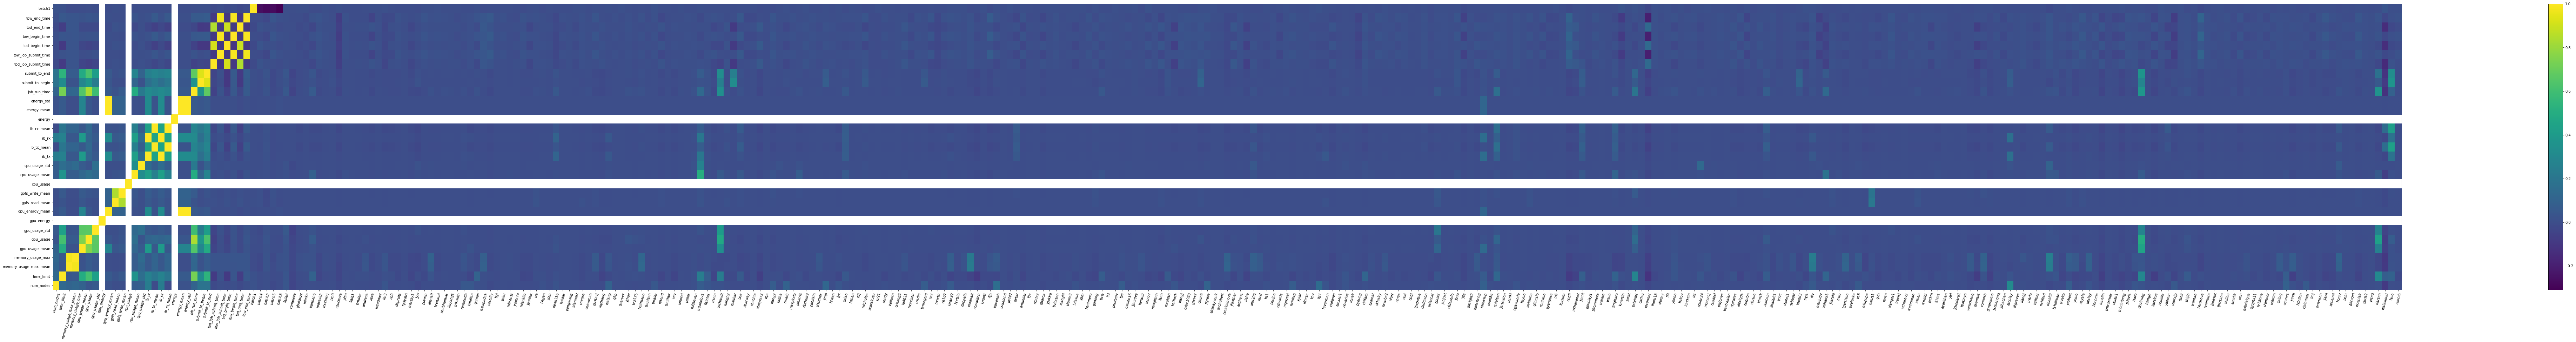

In [40]:
%matplotlib inline 

cHeight = len(uJDF.getDummyCols("_base")) - 3 #+ len(uJDF.getDummyCols("launch_node_name"))

# There's a bug in the spark version?
correlation = pdNDF
sCor        = correlation.head(cHeight)


# Let's do a heatmap
# Generate the correlation heat map and axis
fig, ax = plt.subplots()
hm = plt.pcolor(sCor)

fig.set_figheight(15)
fig.set_figwidth(150)

hm.EdgeColor = [1, 0.7, 0.3];
hm.LineWidth = 6;

# Move ticks and labels to the center
ax.set_xticks(np.arange(sCor.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(sCor.shape[0]) + 0.5, minor=False)

# Insert labels
ax.set_xticklabels(sCor.columns, minor=False)
ax.set_yticklabels(sCor.index, minor=False)

# Rotate label
plt.xticks(rotation=75)

# Plot the color guide and show the correlation
plt.colorbar()
plt.show()

# No Meaningful Change
A visual examination of the normalized correlation set indicates no meaningful change occurs with normalization. As such we'll be moving forward with the unnormalized set.

# Conclusions from Linear Analysis

The linear analysis portion of thhis investigation largely indicated that no one independent variable may be used in prediction of energy usage. It might be possible to construct something with an intersection of `time_limt`, and `num_nodes`. In this data set I know that core `isolation`, `job_type`, `num_gpus`, and `projected_memory` are untouched. `user_flags` Might have some merit, but since  it's closer to nlp it doesn't fit in our linear regression.

# Begin Classification.
Since the regression failed to pull actionable information from the dataset vis a vis `energy`. Perhaps we can find classifiers to indicate  a pending `failure`.



<IPython.core.display.Javascript object>


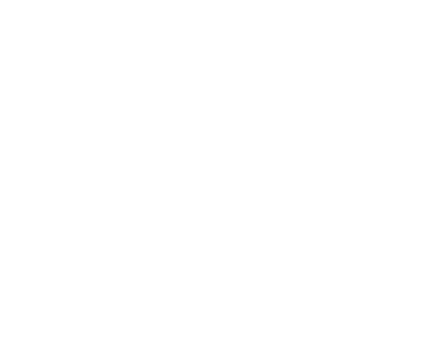

<IPython.core.display.Javascript object>


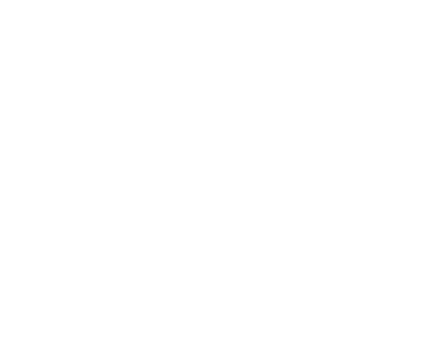

In [23]:

%matplotlib nbagg
matplotlib.use('nbagg')


sns.lmplot(x="num_nodes", y="energy", hue="launch_nodes", data=pdVDF)



In [83]:
# dummyCols = uJDF.getDummyCols()

featuresFull= uJDF.rdd.map(lambda row: row[0:1]+row[4:])# Build the feature rdd.
featureColsFull = ["allocation_id"] + dummyCols[4:]

sFDF = featuresFull.toDF() #.toPandas()
pFDF = sFDF.toPandas()
pFDF.columns = featureColsFull

,allocation_id,num_nodes,time_limit,memory_usage_max_mean,memory_usage_max,gpu_usage_mean,gpu_usage,gpu_usage_std,gpu_energy,gpu_energy_mean,...,hoerz,bnlu,jtkrogel,wozniak,gjost2,josed,rlarsen,walksloud,bjoo,akorzh
0,182736,256,43200,11080624640,20437663744,0,0,0.000000e+00,2.318214e+09,9055522,...,0,0,0,0,0,0,0,0,0,0
1,181476,110,43200,4895041722,4962385920,17858133403807,162346667307,5.732089e+09,3.922139e+09,35655804,...,0,0,0,0,0,0,1,0,0,0
2,185256,12,7200,7724586325,7750811648,1138005,94833,3.145280e+05,7.844400e+04,6537,...,0,0,0,0,0,0,0,1,0,0
3,187776,12,7200,7723674282,7738163200,0,0,0.000000e+00,6.929000e+04,5774,...,0,0,0,0,0,0,0,1,0,0
4,160056,1,600,20513816576,20513816576,52124448,52124448,0.000000e+00,1.046760e+05,104676,...,0,0,0,0,0,0,0,0,0,0


In [84]:
pFDF[pFDF["failed"] == 1]["allocation_id"]

551      177120
1911     182161
2153     159446
2436     168518
2650     180002
3335     178239
3504     176151
3566     160635
4427     168232
4463     177124
4742     179104
5118     160565
5344     165029
5518     168809
5874     185081
5923     183569
6860     177882
7251     158731
7342     163987
7656     160999
7776     158767
7980     169351
8062     183427
8325     159344
8763     180296
10194    168489
10803    161254
10823    164350
10933    168526
11385    158735
          ...  
24742    177360
25098    160656
26568    160910
26588    160262
26612    161486
28053    175383
28280    177219
28287    184779
28581    184239
28856    171028
29272    172036
29647    160265
30133    177113
30190    182441
30224    179885
30753    181974
31180    184242
33093    177152
33097    177224
33145    178376
33288    179852
33751    184173
33961    177117
34636    168765
35047    168442
35487    160702
36127    170063
36300    179099
36383    179171
36715    192995
Name: allocation_id, Len

In [ ]:


%matplotlib nbagg
matplotlib.use('nbagg')


sns.lmplot(x="num_nodes", y="energy", hue="launch_nodes", data=pdVDF)



<IPython.core.display.Javascript object>


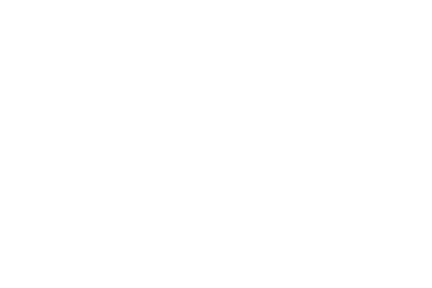

<IPython.core.display.Javascript object>


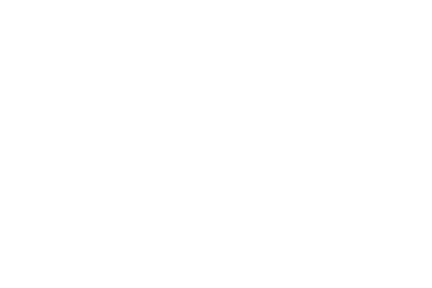

In [24]:
#plt.xticks(rotation=90)
sns.countplot(x='num_nodes', hue="launch_nodes", data=pdVDF)
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)


In [25]:
%matplotlib inline 

#Launch Nodes per user.
uCS = pdVDF[['users',"launch_nodes","num_nodes"]].groupby(['users',"launch_nodes"]).size()
uCS.names=['users',"launch_nodes","count"]
uCS

uCDF = uCS.to_frame("count").unstack(level=1).reset_index()
uCDF.columns = uCDF.columns.droplevel()
uCDF = uCDF.rename(columns = {"" : "user"})

uCDF = uCDF.melt(id_vars=["user"],value_vars=launchNodes,var_name="launch_node", value_name="count")
lnCDF = uCDF.dropna().sort_values(by="user", ascending=False)


In [26]:
uCS = pdVDF[['users',"num_nodes"]]
uMDF=uCS.groupby("users").mean().reset_index().sort_values(by="num_nodes", ascending=False)

<IPython.core.display.Javascript object>


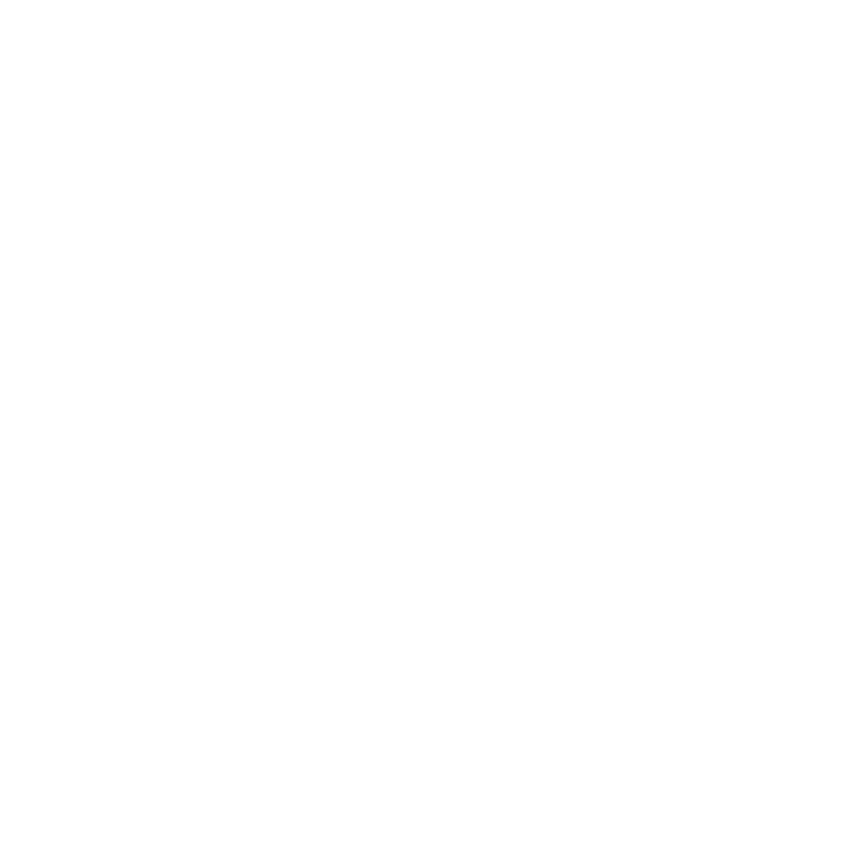

<IPython.core.display.Javascript object>


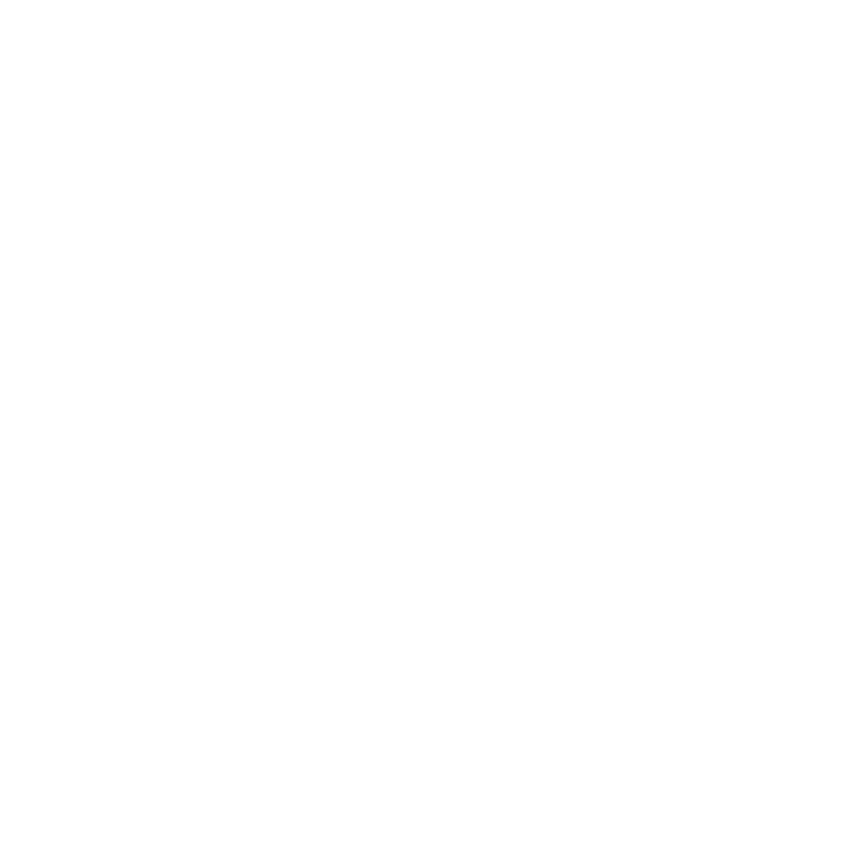

In [42]:
%matplotlib nbagg
matplotlib.use('nbagg')
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)


num_values = 30
labels = ['{0}'.format(n) for n in uMDF["num_nodes"].head(num_values)]

sns.barplot(x='num_nodes',y='users',  data=uMDF.head(num_values))
